In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Setting up image pipeline


In [ ]:
# download dataset
IMAGES_DIR = '/content/data'
try:
  os.makedirs(IMAGES_DIR)
except:
  print('Already exists')

tf.keras.utils.get_file("MelanomaDetection.zip","https://lp-prod-resources.s3.amazonaws.com/278/45149/2021-02-19-19-47-43/MelanomaDetection.zip", extract=True)

Already exists
6758400/6744318 [==============================] - 1s 0us/step


'/root/.keras/datasets/MelanomaDetection.zip'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
import cv2
from keras.preprocessing.image import  img_to_array
from glob import glob
import os
from tqdm.notebook import tqdm

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() ) else "cpu")

In [ ]:
!mv ~/.keras/datasets/MelanomaDetection/ ./data 

In [ ]:
def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

In [ ]:
class UnlabeledImagesDataSet(torch.utils.data.Dataset):
  def __init__(self, dir_path, transform=None):
      super(UnlabeledImagesDataSet, self).__init__()
      self.path = dir_path
      self.transform = transform     
      self.files = glob(os.path.join(self.path,'*.jpg'), recursive=True)  
      self.files.extend(glob(os.path.join(self.path,'*.jpeg'), recursive=True))
      self.files.extend(glob(os.path.join(self.path,'*.png'), recursive=True))
  def __len__(self):
    return len(self.files)

  def __getitem__(self,i):
    img_path =self.files[i]
    #print(f'Getting {img_path}')
    image = Image.open(img_path)   

    if(self.transform):
      image = self.transform(image)

    return image


In [ ]:
class LabeledImagesDataSet(torch.utils.data.Dataset):
  def __init__(self, dir_path, transform=None):
      super(LabeledImagesDataSet, self).__init__()
      self.path = dir_path
      self.transform = transform
      self.data = []    
      self.labels = []
      self.files = glob(os.path.join(self.path,'*.jpg'), recursive=True)  
      self.files.extend(glob(os.path.join(self.path,'*.jpeg'), recursive=True))
      self.files.extend(glob(os.path.join(self.path,'*.png'), recursive=True))    
  def __len__(self):
    return len(self.files)

  def __getitem__(self,i):
        img_path =self.files[i]
       
        image = Image.open(img_path)
        label = 0
        if "_1.jpg" in img_path:
          label = 1        
        return (image,label)

In [ ]:
data_folder = "./data/MelanomaDetection"
labeledDS = LabeledImagesDataSet(os.path.join(data_folder, 'labeled'))

In [ ]:
dataloader = DataLoader(labeledDS, batch_size=4,
                        shuffle=True, num_workers=2)

In [ ]:
unlabeledDS = UnlabeledImagesDataSet(os.path.join(data_folder,'unlabeled'))

In [ ]:
unlabeledDataLoader = DataLoader(unlabeledDS, batch_size=4, shuffle=True, num_workers=2)

Transformations and pre-preprocessing


*   Normalisation of pixel intensities
*   Convert colour to grayscale
*   Augmentation can include
 *  Rotation
 *  Skewing 



In [ ]:
n_channels = 3
n_features = 32 #size of image
rand_input = 100
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


# DCGAN
GAN which employed convolutional and convolutional-transpose layers in both the discriminator and generator.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self,len_input,n_features):
    super(Generator,self).__init__()
    self.ngpu = 1
    self.main = nn.Sequential(
        nn.ConvTranspose2d( len_input, n_features * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_features * 4),
        nn.ReLU(True),
        # state size. (n_features*8) x 4 x 4
        nn.ConvTranspose2d(n_features * 4, n_features * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_features * 2),
        nn.ReLU(True),
        # state size. (n_features*4) x 8 x 8
        nn.ConvTranspose2d( n_features * 2, n_features , 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_features),
        nn.ReLU(True),
        # state size. (n_features*2) x 16 x 16
        # nn.ConvTranspose2d( n_features * 2, n_features, 4, 2, 1, bias=False),
        # nn.BatchNorm2d(n_features),
        # nn.ReLU(True),
        # state size. (n_features) x 32 x 32
        nn.ConvTranspose2d( n_features, n_channels, 4, 2, 1, bias=False),
        nn.Tanh()        
    )
    # self.conv = nn.Conv2d(3,32,kernel_size=3)
    # self.pool = nn.MaxPool2d(2)
    # self.hidden = nn.Linear()
  def forward(self,x):
    return self.main(x)
    #x0 = self.l1(x)


In [ ]:
gen = Generator(rand_input,n_features).to(device)

In [ ]:
#init weights
gen = nn.DataParallel(gen,list(range(1)))

In [ ]:
gen.apply(weights_init)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): Tanh()
    )
  )
)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,n_features):
    super(Discriminator,self).__init__()
    self.ngpu = 1
    self.main = nn.Sequential(
        # input is (nc) x 32 x 32
        nn.Conv2d(n_channels, n_features, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (n_features) x 32 x 32
        nn.Conv2d(n_features, n_features * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_features * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (n_features*2) x 16 x 16
        nn.Conv2d(n_features * 2, n_features * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_features * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (n_features*4) x 8 x 8
        # nn.Conv2d(n_features * 4, n_features * 8, 4, 2, 1, bias=False),
        # nn.BatchNorm2d(n_features * 8),
        # nn.LeakyReLU(0.2, inplace=True),
        # state size. (n_features*8) x 4 x 4
        nn.Conv2d(n_features * 4, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()    
    )

  def forward(self,input):
    return self.main(input)
    

In [ ]:
disc = Discriminator(n_features).to(device)

In [ ]:
disc = nn.DataParallel(disc,list(range(1)))

In [ ]:
disc.apply(weights_init)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (9): Sigmoid()
    )
  )
)

## Unsupervised learning / representational learning

In [ ]:
from torchvision.transforms import transforms
unlabeledDS = UnlabeledImagesDataSet(os.path.join(data_folder,'unlabeled'), transform= transforms.Compose([transforms.ToTensor()]))
unlabeledDataLoader = DataLoader(unlabeledDS, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
import torch.optim as optim
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, rand_input, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
import torchvision.utils as vutils
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
num_epochs = 10
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(1,num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(unlabeledDataLoader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        disc.zero_grad()
        # Format batch
        real_cpu = data.to(device)

        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, rand_input, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[1/10][0/50]	Loss_D: 1.5160	Loss_G: 0.9109	D(x): 0.6265	D(G(z)): 0.6179 / 0.4195
[1/10][50/50]	Loss_D: 0.0728	Loss_G: 3.9607	D(x): 0.9971	D(G(z)): 0.0673 / 0.0201
[1/10][100/50]	Loss_D: 0.4114	Loss_G: 1.2728	D(x): 0.8233	D(G(z)): 0.1728 / 0.2842
[1/10][150/50]	Loss_D: 0.3295	Loss_G: 2.2286	D(x): 0.7922	D(G(z)): 0.0742 / 0.1128
[1/10][200/50]	Loss_D: 0.3761	Loss_G: 2.5382	D(x): 0.8292	D(G(z)): 0.1642 / 0.0843
[1/10][250/50]	Loss_D: 0.3179	Loss_G: 2.7419	D(x): 0.8902	D(G(z)): 0.1676 / 0.0781
[1/10][300/50]	Loss_D: 0.4036	Loss_G: 2.3181	D(x): 0.8105	D(G(z)): 0.1648 / 0.1077
[1/10][350/50]	Loss_D: 0.8256	Loss_G: 2.2104	D(x): 0.8301	D(G(z)): 0.4462 / 0.1226
[1/10][400/50]	Loss_D: 0.8287	Loss_G: 1.5092	D(x): 0.5671	D(G(z)): 0.1977 / 0.2276
[2/10][0/50]	Loss_D: 0.7017	Loss_G: 1.2248	D(x): 0.6172	D(G(z)): 0.1728 / 0.3060
[2/10][50/50]	Loss_D: 0.5162	Loss_G: 1.8371	D(x): 0.6999	D(G(z)): 0.1382 / 0.1651
[2/10][100/50]	Loss_D: 0.3913	Loss_G: 2.7509	D(x): 0.9312	D(G(z)): 

### View progress

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

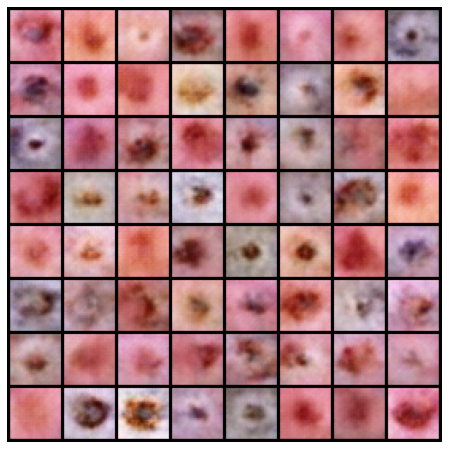

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())